<a href="https://colab.research.google.com/github/jpsiegel/Projects/blob/master/Feudal_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Trello:

### Done
* Minimo viable visual **CHK**
  * particionar matriz gobernador **CHK**
  * particionar matriz señor **CHK**
  * particionar matriz vasallo **CHK**
  * Conectar el update **CHK**
* Actualizar valores por etapa (loyalties y army) **CHK**
  * Actualizar loyalties segun decay rate **CHK**
  * Actualizar armies segun grow rate **CHK**
* arreglar BUG: finds deben funcionar con config no con all_list **CHK**
* Generar reglas
  * segun army_value semi **CHK**
    * vasallo ataca segun fuerza de neighbours: attack lowest army value neighbour if im the strongest of the neighbour (neighbour is all but self) **CHK**
    * si vecino de vasallo controla mas de un feudo a su alrededor, army value se suma (favorece ataque a regiones aisladas o feudos chicos) **CHK**
* Generar consecuencias de conquista
  * Vasallos **chk**
  * Lords
  * Govs

### To Do (entrega3)
* Checkear bugs:
  * que no crucen mapa  **CHK**
  * que no haya conflicto en hitmap: actualmente si mas de uno ataca al mismo, se ejecuta solo 1 de esos aleatoriamente (segun su orden en dict) **CHK**
  * que encuentre target correcto **CHK**
  * que pasa cuando vasallo ataca: le pasa su id a ese cuadro (que pasa con army value? adopta porcion.) **CHK**
  * ctrl f .loyalties_up.keys())[0], hacer misma fn pa lords, si tienen mas de un gov busca el mas alto
  * pasa algo extraño con los lords, no marcan bien sus neighbours cuando van desapareciendo, y al parecer pueden resurgir cuando mueren, ir de a poco con printy=True ayudara a resolverlo
* Hacer ataques y conquistas de lords/govs!! toma toda la region de ese gov/lord
* Generar reglas
  * segun loyalties: vasallo sigue orden superior con probabilidad segun su loyalty, si superior ataca exitosamente con su vasallo, loyalty sube
* Analisis:
  * Grafico de area por gov o lord (histograma simple)
* Hacer funcion generadora de condiciones iniciales



In [1]:
import matplotlib
from pylab import *
from IPython import display
import time
import numpy as np
from random import uniform, seed

In [2]:
# Parameters

vassal_grid_size = 5 # n x n
lord_grid_size = vassal_grid_size - 2
governor_grid_size = lord_grid_size - 1

initial_army_level_min, initial_army_level_max = 0.1, 2  
initial_loyalty_value = 1.0
min_army_growth_rate, max_army_growth_rate = 0.01, 0.1

activity_value = 0.5  # [0,1] higher activity means more probability of attacking
loyalty_decay_rate = 0.01
army_portion_left_on_new_conquest = 0.5
times_stronger_lord = 2 # how many times the army value of a lord has to exceed the ones of his neighbours to attack
times_stronger_gov = 1
loyalty_war_boost = 0.4 #how much loyalty is gained from going to war
conquered_initial_loyalty = 0.5 #how loyal is vassal that was just conquered by a new lord
portion_of_vassal_aid_to_go_to_war = 0.5

In [3]:
# Classes


class Vassal:  # Vasallo

  def __init__(self, id_, initial_army_level, initial_loyalties_up, coord_x, coord_y):
    self.id_ = id_ #este es su nombre, si conquista mas feudos este se traspasa
    self.coords = (coord_x, coord_y) #coordenadas, inmutables
    self.army_value = initial_army_level
    self.loyalties_up = initial_loyalties_up #dict: {L1: loyalty_value1, L2: l_v2}

  def __repr__(self):
    return "Vassal{} c:{}".format(self.id_, self.coords)


class Lord:  # Señor

  def __init__(self, id_, initial_loyalties_up, initial_loyalties_down, last_army_value=0, last_war_vassals=[], last_war_vassals_out=[]):
    self.id_ = id_
    self.loyalties_up = initial_loyalties_up  # dict: {G1: loyalty_value1, G2: l_v2}
    self.loyalties_down = initial_loyalties_down  # dict: {V1: loyalty_value1, V2: l_v2}
    self.last_war_vassals = last_war_vassals
    self.last_war_vassals_out = last_war_vassals_out
    self.last_army_value = last_army_value
    
  def check_state(self):
    """Function to calculate army value of Lord given its loyalties down, 
    also which vassals would or wouldnt go to war with him. Also calls get_neighbours and returns it"""
    all_vassals = []
    for vassal_id, loyalty in self.loyalties_down.items():
      all_vassals.append(vassal_id)
    all_vassal_coords = find_vassals_by_ids(all_vassals)
    neighbours = self.get_neighbours(all_vassal_coords, all_vassals)
    
    army_value_total = 0
    vassals_in = []
    vassals_out = []
    for x, y in all_vassal_coords:
      current_vassal = vassal_nextconfig[x, y]
      try:
        vassal_loyalty = current_vassal.loyalties_up[self.id_]
        lord_loyalty = self.loyalties_down[current_vassal.id_]
      except KeyError:
        print("no encontramos al lord en el loyalties up de su vasallo")
      if uniform(0, 1) < vassal_loyalty * lord_loyalty: #vassals will go to war depending on his loyalty
        army_value_total += current_vassal.army_value * vassal_loyalty
        vassals_in.append(current_vassal.id_)
      else:
        vassals_out.append(current_vassal.id_)
    self.last_army_value = army_value_total #every time army value is calculated, it is saved to pass as info to gov #BUG: last army value is not updated with this iterations lord conquests
    return army_value_total, list(set(vassals_in)), list(set(vassals_out)), neighbours

  def get_neighbours(self, vassal_coords=None, vassal_ids=None):
    """returns attackable neighbours of lord"""
    if vassal_coords is None or vassal_ids is None: #if params are none, gets required data
      vassal_ids = []
      for vassal_id, loyalty in self.loyalties_down.items():
        vassal_ids.append(vassal_id)
      vassal_coords = find_vassals_by_ids(vassal_ids)

    neighbour_ids = []
    for x, y in vassal_coords:
      current_vassal = vassal_nextconfig[x, y]
      cross_neighbourhood = [(0, 1), (1, 0), (0, -1), (-1, 0)] #not checking diagonals

      for dx, dy in cross_neighbourhood:
        try:
          current_neighbour = vassal_nextconfig[x + dx, y + dy]
        except IndexError: #skip if coords out of map
          continue
        distance = abs((current_neighbour.coords[0] + current_neighbour.coords[1]) - (current_vassal.coords[0] + current_vassal.coords[1]))
        if distance > 2: #skip if its not direct neighbour (was causing bug when x + dx was 0 + -1)
          continue

        if current_neighbour.id_ in vassal_ids:  # skip if neighbour is vassal of self
          continue
        else: # if it hasnt skipped by now, we have a neighbour cell that is other lord
          lord_id = list(current_neighbour.loyalties_up.keys())[0] #aca considerar mas de un gov por conqusita de govs
          neighbour_ids.append(lord_id)
      
    return list(set(neighbour_ids))

  def __repr__(self):
    return "Lord{} l_down:{}".format(self.id_, self.loyalties_down)


class Governor:  # Gobernador

  def __init__(self, id_, initial_loyalties_down):
    self.id_ = id_
    self.loyalties_down = initial_loyalties_down  # dict: {L1: loyalty_value1, L2: l_v2}
    self.last_war_lords = [] #ids of last lords who went with him to war
    self.last_war_lords_out = [] #didnt go
    
  def check_state(self):
    """Function to calculate army value of Governor given its loyalties down, 
    also which lords would or wouldnt go to war with him. Also calls get_neighbours and returns it"""
    all_lords = []
    for lord_id, loyalty in self.loyalties_down.items():
      all_lords.append(lord_id)
    all_lord_coords = find_lords_by_ids(all_lords)
    neighbours = self.get_neighbours(all_lord_coords, all_lords)
    
    army_value_total = 0
    lords_in = []
    lords_out = []
    for x, y in all_lord_coords:
      current_lord = lord_nextconfig[x, y]
      try:
        lord_loyalty = current_lord.loyalties_up[self.id_]
        gov_loyalty = self.loyalties_down[current_lord.id_]
      except KeyError:
        print("no encontramos al governor en el loyalties up de su lord")
      if uniform(0, 1) < lord_loyalty * gov_loyalty: #lords will go to war depending on his loyalty
        print("adding {}*{} to {} from lord {} to gov {}".format(current_lord.last_army_value, lord_loyalty, army_value_total, current_lord.id_, self.id_))
        army_value_total += current_lord.last_army_value * lord_loyalty
        lords_in.append(current_lord.id_)
      else:
        lords_out.append(current_lord.id_)
    return army_value_total, list(set(lords_in)), list(set(lords_out)), neighbours

  def get_neighbours(self, lord_coords, lord_ids):
    """returns attackable neighbours of gov"""
    lord_neighbour_ids = []
    for x, y in lord_coords: #find all neighbours of lords of this gov
      current_lord = lord_nextconfig[x, y]
      current_lord_neighbours = current_lord.get_neighbours()
      lord_neighbour_ids.extend(current_lord_neighbours)

    gov_nieghbours_ids = []
    for lord_id in list(set(lord_neighbour_ids)):
      if lord_id in lord_ids: #is also lord of self
        continue
      else: #this lord is of enemy governor, therefore that governor is neighbour
        lord = find_lord_by_id(lord_id)
        gov_id = list(lord.loyalties_up.keys())[0]  # id of first gov connected, but
        if len(lord.loyalties_up.keys()) > 1: #if he has more than one connection, choose most loyal
          most_loyal = max(lord.loyalties_up.values())
          for id__, value in lord.loyalties_up.items():
            if value == most_loyal:
              gov_id = id__
              break
        gov_nieghbours_ids.append(gov_id)
    return gov_nieghbours_ids

  def __repr__(self):
    return "Governor{} l_down:{}".format(self.id_, self.loyalties_down)

In [4]:
#Auxiliar functions

def connect_down(A, B, value=initial_loyalty_value):
  """Connects A down to B. A will have a loyalties_down pointing to B.
  B will have a loyalties_up pointing to A"""
  A.loyalties_down[B.id_] = value
  B.loyalties_up[A.id_] = value

def connect_all():
  """ Given a grid size, this generates random valid starting conditions for the connections"""
  pass

def print_connections(vassal_config, lord_config, governor_config):
    print("Vassal Config:")
    print(vassal_config)
    print("")
    print("Lord Config:")
    print(lord_config)
    print("")
    print("Governor Config:")
    print(governor_config)
    print("")

def find_lord_of_vassal(vassal):
  """ Given a vassal object, returns the lord object connected with him """
  lord_id = list(vassal.loyalties_up.keys())[0]  # id of first lord connected, but

  if len(vassal.loyalties_up.keys()) > 1: #if he has more than one connection, choose most loyal
    most_loyal = max(vassal.loyalties_up.values())
    for id__, value in vassal.loyalties_up.items():
      if value == most_loyal:
        lord_id = id__
        break

  target_lord = None
  for x in range(lord_grid_size):
    for y in range(lord_grid_size):
      if lord_config[x,y].id_ == lord_id:
        target_lord = lord_config[x,y]
        return target_lord
  if target_lord == None:
    raise ValueError("Vassal's lord not found in lord_config")

def find_lord_by_id(id_):
  """ Given a id, returns the lord object of that id"""
  target_lord = None
  for x in range(lord_grid_size):
    for y in range(lord_grid_size):
      if lord_nextconfig[x,y].id_ == id_:
        target_lord = lord_nextconfig[x,y]
        return target_lord
  if target_lord == None:
    raise ValueError("Lord not found in nextlord_config")

def find_governor_by_id(id_):
  """ Given a id, returns the governor object of that id"""
  target_gov = None
  for x in range(governor_grid_size):
    for y in range(governor_grid_size):
      if governor_nextconfig[x,y].id_ == id_:
        target_gov = governor_nextconfig[x,y]
        return target_gov
  if target_gov == None:
    raise ValueError("Governor not found in nextgovernor_config")

def find_governor_of_vassal(vassal):
  """ Given a vassal object, returns the governor object connected with him through a lord"""
  lord = find_lord_of_vassal(vassal)
  governor_id = list(lord.loyalties_up.keys())[0]  # id of first governor connected # considerar mas de un gov
  target_governor = None
  for x in range(governor_grid_size):
    for y in range(governor_grid_size):
      if governor_config[x, y].id_ == governor_id:
        target_governor = governor_config[x, y]
        return target_governor
  if target_governor == None:
    raise ValueError("Vassal's governor not found in governor_config")

def find_vassals_by_ids(vassal_id_list):
  """given a list of vassal ids, returns tuple list of the 
  coordinates of all vassal cells that have one of those ids"""
  vassal_coords = []
  for x in range(vassal_grid_size):
    for y in range(vassal_grid_size):
      if vassal_nextconfig[x,y].id_ in vassal_id_list:
        vassal_coords.append((x, y))
  return vassal_coords

def find_lords_by_ids(lord_id_list):
  """given a list of lord ids, returns tuple list of the 
  coordinates of all lord cells that have one of those ids"""
  lord_coords = []
  for x in range(lord_grid_size):
    for y in range(lord_grid_size):
      if lord_nextconfig[x,y].id_ in lord_id_list:
        lord_coords.append((x, y))
  return lord_coords



In [5]:
# backend

def initialize(pattern=1, printy=False):
    global vassal_config, vassal_nextconfig, lord_config, lord_nextconfig, governor_config, governor_nextconfig, all_vassals, all_lords, all_governors
    seed(pattern)  # if uncommented, all executions give same pattern of army values

    #initialize vassal level
    vassal_config = np.zeros([vassal_grid_size, vassal_grid_size], dtype=type(Vassal(None, 1, {}, -1, -1)))

    id_counter = 1
    for x in range(vassal_grid_size):
      for y in range(vassal_grid_size):
        initial_army_level = round(uniform(initial_army_level_min, initial_army_level_max), 3)
        new_vassal = Vassal(id_counter, initial_army_level, {}, x, y)
        vassal_config[x, y] = new_vassal
        id_counter += 1

    vassal_nextconfig = np.zeros([vassal_grid_size, vassal_grid_size], dtype=type(Vassal(None, 1, {}, -1, -1)))

    #initialize lord level
    lord_config = np.zeros([lord_grid_size, lord_grid_size], dtype=type(Lord(None, {}, {})))

    id_counter = 1
    for x in range(lord_grid_size):
      for y in range(lord_grid_size):
        new_lord = Lord(id_counter, {}, {})
        lord_config[x, y] = new_lord
        id_counter += 1

    lord_nextconfig = np.zeros([lord_grid_size, lord_grid_size], dtype=type(Lord(None, {}, {})))

    #initialize governor level
    governor_config = np.zeros([governor_grid_size, governor_grid_size], dtype=type(Governor(None, {})))

    id_counter = 1
    for x in range(governor_grid_size):
      for y in range(governor_grid_size):
        new_governor = Governor(id_counter, {})
        governor_config[x, y] = new_governor
        id_counter += 1

    governor_nextconfig = np.zeros([governor_grid_size, governor_grid_size], dtype=type(Governor(None, {})))

    #connect all levels (random initial condition (WIP))
    #connect_all()
    
    #connect all levels (deterministic initial condition)
    #connect govs
    #1st gov
    connect_down(governor_config[0,0], lord_config[0, 0])
    connect_down(governor_config[0,0], lord_config[1, 0])
    #2nd gov
    connect_down(governor_config[0,1], lord_config[0, 1])
    connect_down(governor_config[0,1], lord_config[0, 2])
    #3rd gov
    connect_down(governor_config[1,0], lord_config[1, 1])
    connect_down(governor_config[1,0], lord_config[1, 2])
    connect_down(governor_config[1,0], lord_config[2, 2])
    #4th gov
    connect_down(governor_config[1,1], lord_config[2, 0])
    connect_down(governor_config[1,1], lord_config[2, 1])
    
    #connect lords
    #1st lord
    connect_down(lord_config[0,0], vassal_config[0, 0])
    connect_down(lord_config[0,0], vassal_config[1, 0])
    connect_down(lord_config[0,0], vassal_config[0, 1])
    #2do lord
    connect_down(lord_config[0,1], vassal_config[0, 2])
    connect_down(lord_config[0,1], vassal_config[1, 2])
    connect_down(lord_config[0,1], vassal_config[0, 3])
    #3rd lord
    connect_down(lord_config[0,2], vassal_config[1, 3])
    connect_down(lord_config[0,2], vassal_config[0, 4])
    connect_down(lord_config[0,2], vassal_config[1, 4])
    connect_down(lord_config[0,2], vassal_config[2, 4])
    #4th lord
    connect_down(lord_config[1,0], vassal_config[2, 0])
    connect_down(lord_config[1,0], vassal_config[1, 1])
    connect_down(lord_config[1,0], vassal_config[2, 1])
    #5th lord
    connect_down(lord_config[1,1], vassal_config[2, 2])
    connect_down(lord_config[1,1], vassal_config[3, 2])
    connect_down(lord_config[1,1], vassal_config[2, 3])
    #6th lord
    connect_down(lord_config[1,2], vassal_config[3, 3])
    connect_down(lord_config[1,2], vassal_config[3, 4])
    connect_down(lord_config[1,2], vassal_config[4, 4])
    #7th lord
    connect_down(lord_config[2,0], vassal_config[3, 0])
    connect_down(lord_config[2,0], vassal_config[4, 0])
    #8th lord
    connect_down(lord_config[2,1], vassal_config[3, 1])
    connect_down(lord_config[2,1], vassal_config[4, 1])
    #9th lord
    connect_down(lord_config[2,2], vassal_config[4, 2])
    connect_down(lord_config[2,2], vassal_config[4, 3])

    if printy:
      print_connections(vassal_config, lord_config, governor_config)


def observe(year, ca_level, color_map):
    global vassal_config, vassal_nextconfig, lord_config, lord_nextconfig, governor_config, governor_nextconfig
    cla()
    if ca_level == "vassal":  # plot vassal level
      aux_config = np.zeros([vassal_grid_size, vassal_grid_size])
      for x in range(vassal_grid_size):
        for y in range(vassal_grid_size):
          aux_config[x,y] = vassal_config[x,y].id_ #cambia instancia por id
      
    if ca_level == "lord":  # plot lord level
      aux_config = np.zeros([vassal_grid_size, vassal_grid_size])
      for x in range(vassal_grid_size):
        for y in range(vassal_grid_size): 
          # cambia instancia de vassal por id del primer lord conectado
          # normalizamos para usar toda la escala de colores
          lord_id = find_lord_of_vassal(vassal_config[x,y]).id_
          normalized_id = (vassal_grid_size / lord_grid_size) * (lord_id - 1)
          aux_config[x,y] = normalized_id  

    if ca_level == "governor":  # plot governor level
      aux_config = np.zeros([vassal_grid_size, vassal_grid_size])
      for x in range(vassal_grid_size):
        for y in range(vassal_grid_size):
          # cambia instancia de vassal por id del primer gov conectado
          # normalizamos para usar toda la escala de colores
          gov_id = find_governor_of_vassal(vassal_config[x,y]).id_
          normalized_id = (vassal_grid_size / governor_grid_size) * (gov_id - 1) 
          aux_config[x,y] = normalized_id  

    imshow(aux_config, vmin = 0, vmax = vassal_grid_size * vassal_grid_size, cmap = color_map)
    #print_connections(vassal_config, lord_config, governor_config)

def update(printy=False):
  """ First we update army_value and loyalties for all vassals/lords/govs, then we generate decisions/actions for gov,lord,vassal """
  global vassal_config, vassal_nextconfig, lord_config, lord_nextconfig, governor_config, governor_nextconfig

  vassal_hitmap = {}  # {attacker_coords: target_coords}
  # iterate through VASSAL grid
  for x in range(vassal_grid_size):
    for y in range(vassal_grid_size):
      # update grid with new values
      current_vassal = vassal_config[x, y]
      growth_factor = 1 + uniform(min_army_growth_rate, max_army_growth_rate)  # in each step army value grows
      updated_army_value = round(current_vassal.army_value * growth_factor, 3)
      updated_loyalties = {k: v * (1 - loyalty_decay_rate) for k, v in current_vassal.loyalties_up.items()}  # in each step loyalty decays
      vassal_nextconfig[x, y] = Vassal(current_vassal.id_, updated_army_value, updated_loyalties, x, y)
      current_vassal = vassal_nextconfig[x, y]

      if uniform(0,1) > activity_value: #some chance to skip vassal
        continue

      # iterate through neighbourhood
      neighbours_army_values = {}  # coords: value
      aux_army_values = {} # id: value, es para sumar los del mismo id
      for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
          try:
            current_neighbour = vassal_config[x + dx, y + dy]
          except IndexError: #skip if coords out of map
            continue

          distance = abs((current_neighbour.coords[0] + current_neighbour.coords[1]) - (current_vassal.coords[0] + current_vassal.coords[1]))
          if distance > 2: #skip if its not direct neighbour (was causing bug when x + dx was 0 + -1)
            continue

          if current_neighbour.id_ != current_vassal.id_:  # skip if self
            try:
              neighbours_army_values[current_neighbour.coords] += current_neighbour.army_value
              aux_army_values[current_neighbour.id_] += current_neighbour.army_value
            except KeyError:
              neighbours_army_values[current_neighbour.coords] = current_neighbour.army_value
              aux_army_values[current_neighbour.id_] = current_neighbour.army_value

      # vassal attack rules
      if len(neighbours_army_values) > 0 and current_vassal.army_value >= max(aux_army_values.values()):  # if stronger than neighbours (added by ids)
        target_vassal_coords = min(neighbours_army_values.keys(), key=(lambda k: neighbours_army_values[k]))  # attacks weakest neighbour
        vassal_hitmap[current_vassal.coords] = target_vassal_coords

  if printy:
    print("Hitmap")
    print(vassal_hitmap)
  
  # after all attacks are checked (all vassals are in nextconfig)
  # consequences of vassal attacks
  for attacker_coords, target_coords in vassal_hitmap.items():
    attacker = vassal_nextconfig[attacker_coords[0], attacker_coords[1]]
    target = vassal_nextconfig[target_coords[0], target_coords[1]]
    target.id_ = attacker.id_
    target.loyalties_up = attacker.loyalties_up #loyalties are passed to conqueror

  # iterate through LORD grid ##################################################
  lords_army_values = {}  # id: value
  lords_neighbourhood = {} # id: ids (if lord neighbourhood is empty, lord was defeated)
  for x in range(lord_grid_size):
    for y in range(lord_grid_size):
      current_lord = lord_config[x, y]
      updated_loyalties_up = {k: v * (1 - loyalty_decay_rate) for k, v in current_lord.loyalties_up.items()}  # in each step loyalty decays by loyalty_decay_rate
      updated_loyalties_down = {k: v * (1 - loyalty_decay_rate) for k, v in current_lord.loyalties_down.items()}
      lord_nextconfig[x, y] = Lord(current_lord.id_, updated_loyalties_up, updated_loyalties_down, current_lord.last_army_value, current_lord.last_war_vassals, current_lord.last_war_vassals_out)
      current_lord = lord_nextconfig[x, y]

      #lord checks his state (calcualtes army value and neighbours)
      current_army_value, vassals_in, vassals_out, neighbour_ids = current_lord.check_state()
      current_lord.last_war_vassals = vassals_in # lord remembers who aided him in war
      current_lord.last_war_vassals_out = vassals_out
      lords_army_values[current_lord.id_] = current_army_value
      lords_neighbourhood[current_lord.id_] = neighbour_ids

  #iterate again so all army values and neighbourhoods are already updated 
  lord_hitmap = {}  
  for x in range(lord_grid_size):
    for y in range(lord_grid_size):
      current_lord = lord_nextconfig[x, y]
      current_neighbours = lords_neighbourhood[current_lord.id_]
      current_army_value = lords_army_values[current_lord.id_]
      current_neighbours_army_values = {id__: lords_army_values[id__] for id__ in current_neighbours}

      #lord attack rules
      if len(current_neighbours) > 0 and current_army_value >= times_stronger_lord * max(current_neighbours_army_values.values()):  # if times_stronger than neighbours
        if True: #len(current_lord.last_war_vassals) > len(current_lord.last_war_vassals_out): # only attacks if majority of vassals aids him
          target_lord_id = min(current_neighbours_army_values.keys(), key=(lambda k: current_neighbours_army_values[k]))  # attacks weakest neighbour
          lord_hitmap[current_lord.id_] = target_lord_id
          for vassal_id in current_lord.last_war_vassals:
            current_lord.loyalties_down[vassal_id] = max(1, current_lord.loyalties_down[vassal_id] + loyalty_war_boost) #loyalty is boosted for aiding in war
            #bug: should update vassal loyalty up
            #bug: if hitmap collision occurs, loyalty will be boosted even tho no conquest was made

  if printy or True:
    print("Army Values Lords: ", lords_army_values)
    print("Neighbours Lords: ", lords_neighbourhood)
    print("Lord Hitmap: ", lord_hitmap)

  #consequences of lord attacking
  for attacker_id, target_id in lord_hitmap.items():
    attacker = find_lord_by_id(attacker_id)
    target = find_lord_by_id(target_id)

    for vassal_id in target.loyalties_down.keys():
      vassals_coords = find_vassals_by_ids([vassal_id])
      for vassal_coord_x, vassal_coord_y in vassals_coords:
        vassal_ = vassal_nextconfig[vassal_coord_x, vassal_coord_y]
        connect_down(attacker, vassal_, conquered_initial_loyalty) #attacker and vassal are connected
        vassal_.loyalties_up[target.id_] = 0 # and vassal is no longer loyal to defeated lord

  # iterate through GOVERNOR grid ##############################################
  govs_army_values = {}  # id: value
  govs_neighbourhood = {} # id: ids (if governor neighbourhood is empty, governor was defeated)
  for x in range(governor_grid_size):
    for y in range(governor_grid_size):
      current_gov = governor_config[x, y]
      updated_loyalties_down = {k: v * (1 - loyalty_decay_rate) for k, v in current_gov.loyalties_down.items()}
      governor_nextconfig[x, y] = Governor(current_gov.id_, updated_loyalties_down)
      current_gov = governor_nextconfig[x, y]

      #gov checks his state (calcualtes army value and neighbours)
      current_army_value, lords_in, lords_out, neighbour_ids = current_gov.check_state()
      current_gov.last_war_lords = lords_in # gov remembers who aided him in war
      current_gov.last_war_lords_out = lords_out
      govs_army_values[current_gov.id_] = current_army_value
      govs_neighbourhood[current_gov.id_] = neighbour_ids

  #iterate again so all army values and neighbourhoods are already updated 
  gov_hitmap = {}  
  for x in range(governor_grid_size):
    for y in range(governor_grid_size):
      current_gov = governor_nextconfig[x, y]
      current_neighbours = govs_neighbourhood[current_gov.id_]
      current_army_value = govs_army_values[current_gov.id_]
      current_neighbours_army_values = {id__: govs_army_values[id__] for id__ in current_neighbours}

      #gov attack rules
      if len(current_neighbours) > 0 and current_army_value >= times_stronger_gov * max(current_neighbours_army_values.values()):  # if times_stronger than neighbours
        if True: #len(current_lord.last_war_vassals) > len(current_lord.last_war_vassals_out): # only attacks if majority of vassals aids him
          target_gov_id = min(current_neighbours_army_values.keys(), key=(lambda k: current_neighbours_army_values[k]))  # attacks weakest neighbour
          gov_hitmap[current_gov.id_] = target_gov_id
          for lord_id in current_gov.last_war_lords:
            current_gov.loyalties_down[lord_id] = max(1, current_gov.loyalties_down[lord_id] + loyalty_war_boost) #loyalty is boosted for aiding in war
            #bug: should update lord loyalty up
            #bug: if hitmap collision occurs, loyalty will be boosted even tho no conquest was made

  if printy or True:
    print("Army Values Govs: ", govs_army_values)
    print("Neighbours Govs: ", govs_neighbourhood)
    print("Govs Hitmap: ", gov_hitmap)

  #consequences of governor attacking
  for attacker_id, target_id in gov_hitmap.items():
    attacker = find_governor_by_id(attacker_id)
    target = find_governor_by_id(target_id)

    for lord_id in target.loyalties_down.keys():
      affected_lord = find_lord_by_id(lord_id)
      connect_down(attacker, affected_lord, conquered_initial_loyalty) #gov attacker and lord are connected
      affected_lord.loyalties_up[target.id_] = 0 # and lord is no longer loyal to defeated gov

  #reset for next iteration
  vassal_config, vassal_nextconfig = vassal_nextconfig, vassal_config
  lord_config, lord_nextconfig = lord_nextconfig, lord_config
  governor_config, governor_nextconfig = governor_nextconfig, governor_config

Initial Pattern?: 8
Pattern: 8; Year: 0
Army Values Lords:  {1: 3.17493, 2: 2.06217, 3: 2.9601, 4: 4.5936, 5: 2.96901, 6: 2.78289, 7: 1.54242, 8: 0.32769000000000004, 9: 2.87199}
Neighbours Lords:  {1: [4], 2: [3, 4, 5], 3: [2, 5, 6], 4: [1, 2, 5, 7], 5: [2, 3, 4, 6, 7, 9], 6: [9, 3, 5], 7: [8, 4, 5], 8: [9, 7], 9: [8, 5, 6]}
Lord Hitmap:  {}
adding 3.17493*0.99 to 0 from lord 1 to gov 1
adding 4.5936*0.99 to 3.1431807 from lord 4 to gov 1
adding 2.06217*0.99 to 0 from lord 2 to gov 2
adding 2.9601*0.99 to 2.0415483 from lord 3 to gov 2
adding 2.96901*0.99 to 0 from lord 5 to gov 3
adding 2.78289*0.99 to 2.9393199 from lord 6 to gov 3
adding 2.87199*0.99 to 5.694381 from lord 9 to gov 3
adding 1.54242*0.99 to 0 from lord 7 to gov 4
adding 0.32769000000000004*0.99 to 1.5269958 from lord 8 to gov 4
Army Values Govs:  {1: 7.6908446999999995, 2: 4.9720473, 3: 8.5376511, 4: 1.8514089}
Neighbours Govs:  {1: [2, 3, 4], 2: [1, 3, 3], 3: [2, 2, 1, 4, 4], 4: [1, 3, 3]}
Govs Hitmap:  {3: 4}


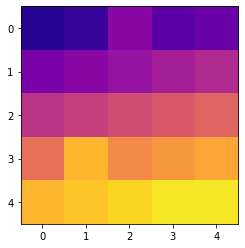

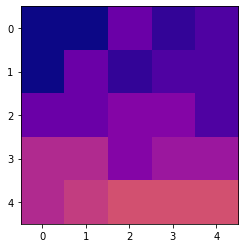

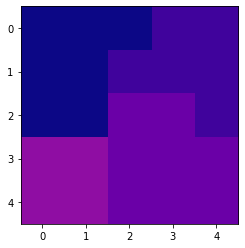

Pattern: 8; Year: 1
Army Values Lords:  {1: 2.6247078, 2: 2.1483792, 3: 2.4865136999999997, 4: 5.3337042, 5: 2.8168074, 6: 2.9452005000000003, 7: 1.9356974999999998, 8: 0, 9: 3.0334095}
Neighbours Lords:  {1: [4], 2: [3, 4], 3: [2, 5], 4: [1, 2, 5, 7], 5: [3, 4, 6, 7, 9], 6: [9, 5], 7: [9, 4, 5], 8: [], 9: [5, 6, 7]}
Lord Hitmap:  {}
adding 2.6247078*0.9801 to 0 from lord 1 to gov 1
adding 5.3337042*0.9801 to 2.5724761147799997 from lord 4 to gov 1
adding 2.1483792*0.9801 to 0 from lord 2 to gov 2
adding 2.4865136999999997*0.9801 to 2.10562645392 from lord 3 to gov 2
adding 2.8168074*0.9801 to 0 from lord 5 to gov 3
adding 2.9452005000000003*0.9801 to 2.76075293274 from lord 6 to gov 3
adding 3.0334095*0.9801 to 5.64734394279 from lord 9 to gov 3
Army Values Govs:  {1: 7.800039601199999, 2: 4.54265853129, 3: 8.62038859374, 4: 0}
Neighbours Govs:  {1: [2, 3, 3], 2: [1, 3], 3: [2, 1], 4: [3, 1, 3]}
Govs Hitmap:  {3: 2}


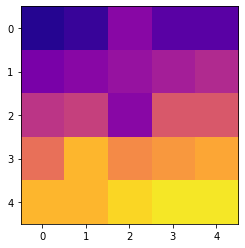

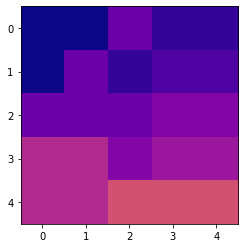

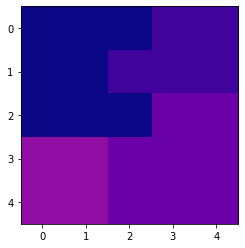

Pattern: 8; Year: 2
Army Values Lords:  {1: 3.3863435099999997, 2: 2.9497089599999997, 3: 2.597490423, 4: 4.736029418999999, 5: 3.573611217, 6: 3.362086035, 7: 1.981350558, 8: 0, 9: 2.972025837}
Neighbours Lords:  {1: [2, 4], 2: [1, 3, 4, 5], 3: [2, 5], 4: [1, 2, 5, 7], 5: [2, 3, 4, 6, 7, 9], 6: [9, 5], 7: [9, 4, 5], 8: [], 9: [5, 6, 7]}
Lord Hitmap:  {}
adding 3.3863435099999997*0.9702989999999999 to 0 from lord 1 to gov 1
adding 4.736029418999999*0.9702989999999999 to 3.2857657214094895 from lord 4 to gov 1
adding 3.573611217*0.9702989999999999 to 0 from lord 5 to gov 3
adding 3.362086035*0.9702989999999999 to 3.4674713902438827 from lord 6 to gov 3
adding 0*0.49005 to 6.729700107918347 from lord 8 to gov 3
adding 2.972025837*0.9702989999999999 to 6.729700107918347 from lord 9 to gov 3
Army Values Govs:  {1: 7.88113033063577, 2: 0, 3: 9.61345380553361, 4: 0}
Neighbours Govs:  {1: [3, 3, 3], 2: [1, 1, 3], 3: [1, 1], 4: [3, 1, 3]}
Govs Hitmap:  {3: 1}


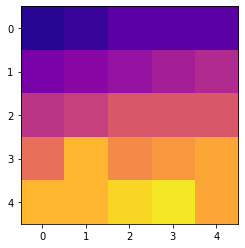

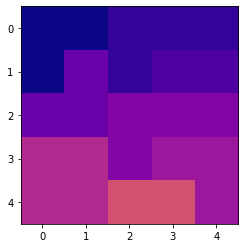

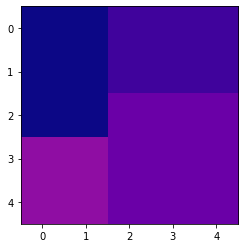

Pattern: 8; Year: 3
Army Values Lords:  {1: 1.23724766088, 2: 0.94330528182, 3: 2.66181154371, 4: 5.348598583679999, 5: 3.7943542394999996, 6: 3.3899433192899995, 7: 2.0720055935699997, 8: 0, 9: 3.03260160357}
Neighbours Lords:  {1: [4], 2: [3, 4, 5], 3: [2, 5], 4: [1, 2, 5, 7], 5: [2, 3, 4, 6, 7, 9], 6: [9, 5], 7: [9, 4, 5], 8: [], 9: [5, 6, 7]}
Lord Hitmap:  {}
adding 3.7943542394999996*0.96059601 to 0 from lord 5 to gov 3
adding 3.3899433192899995*0.96059601 to 3.644841542990284 from lord 6 to gov 3
adding 3.03260160357*0.96059601 to 6.901207569626413 from lord 9 to gov 3
Army Values Govs:  {1: 0, 2: 0, 3: 9.814312569935357, 4: 0}
Neighbours Govs:  {1: [3, 3, 3], 2: [3, 3], 3: [], 4: [3, 3, 3]}
Govs Hitmap:  {}


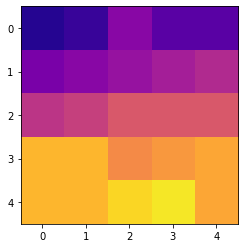

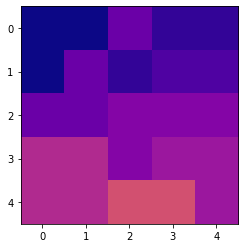

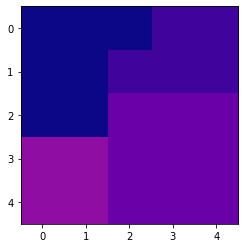

Pattern: 8; Year: 4
Army Values Lords:  {1: 3.7240770354083996, 2: 2.8577250999494996, 3: 2.7160275825144, 4: 5.566144762064699, 5: 4.0645314732726, 6: 3.5985463488215994, 7: 2.2414835476143, 8: 0, 9: 3.0897666721250996}
Neighbours Lords:  {1: [4], 2: [3, 4, 5], 3: [2, 5], 4: [1, 2, 5, 7], 5: [2, 3, 4, 6, 7, 9], 6: [9, 5], 7: [9, 4, 5], 8: [], 9: [5, 6, 7]}
Lord Hitmap:  {}
adding 3.7240770354083996*0.49005 to 0 from lord 1 to gov 3
adding 4.0645314732726*0.9509900498999999 to 1.8249839512018862 from lord 5 to gov 3
adding 3.5985463488215994*0.9509900498999999 to 5.690312939789516 from lord 6 to gov 3
adding 3.0897666721250996*0.9509900498999999 to 9.112494711622832 from lord 9 to gov 3
Army Values Govs:  {1: 0, 2: 0, 3: 12.050832073326436, 4: 0}
Neighbours Govs:  {1: [3, 3, 3], 2: [3, 3], 3: [], 4: [3, 3, 3]}
Govs Hitmap:  {}


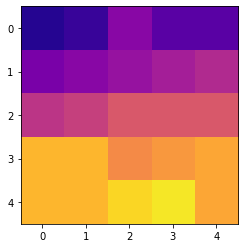

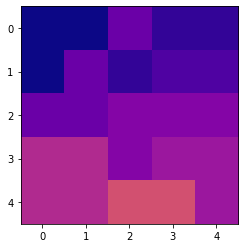

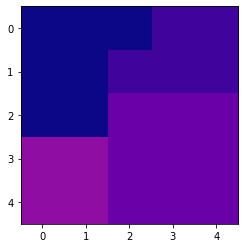

Pattern: 8; Year: 5
Army Values Lords:  {1: 3.9005522589683426, 2: 2.3828862581339303, 3: 0, 4: 5.806108081355967, 5: 4.893813816586397, 6: 3.4778276718872934, 7: 2.3292218896180734, 8: 0, 9: 2.6257881366793887}
Neighbours Lords:  {1: [4], 2: [3, 4], 3: [2, 5], 4: [1, 2, 5, 7], 5: [3, 4, 6, 7, 9], 6: [9, 5], 7: [9, 4, 5], 8: [], 9: [5, 6, 7]}
Lord Hitmap:  {}
adding 0*0.480298005 to 0 from lord 3 to gov 3
adding 5.806108081355967*0.48514949999999996 to 0.0 from lord 4 to gov 3
adding 4.893813816586397*0.9414801494009999 to 2.8168304326158067 from lord 5 to gov 3
adding 3.4778276718872934*0.9414801494009999 to 7.4242589957962455 from lord 6 to gov 3
adding 2.6257881366793887*0.9414801494009999 to 10.698564711915626 from lord 9 to gov 3
Army Values Govs:  {1: 0, 2: 0, 3: 13.17069211913191, 4: 0}
Neighbours Govs:  {1: [3, 3, 3], 2: [3, 3], 3: [], 4: [3, 3, 3]}
Govs Hitmap:  {}


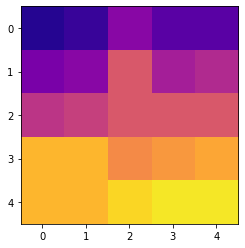

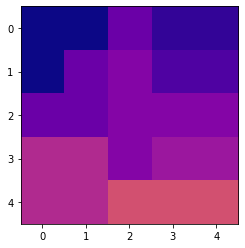

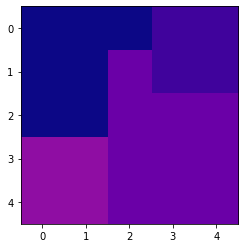

Pattern: 8; Year: 6
Army Values Lords:  {1: 4.134641883315407, 2: 0.3830788579897728, 3: 1.2433751741079246, 4: 3.2873944820679535, 5: 4.141166340750756, 6: 1.2238018018018777, 7: 2.23882096567259, 8: 0, 9: 3.4756716823451654}
Neighbours Lords:  {1: [4], 2: [3, 4], 3: [2, 4, 5], 4: [1, 2, 3, 5, 7], 5: [3, 4, 6, 7, 9], 6: [9, 5], 7: [9, 4, 5], 8: [], 9: [5, 6, 7]}
Lord Hitmap:  {}
adding 4.134641883315407*0.480298005 to 0 from lord 1 to gov 3
adding 4.141166340750756*0.9320653479069899 to 1.9858602479458325 from lord 5 to gov 3
adding 1.2238018018018777*0.9320653479069899 to 5.845697894078402 from lord 6 to gov 3
adding 3.4756716823451654*0.9320653479069899 to 6.98636114624407 from lord 9 to gov 3
Army Values Govs:  {1: 0, 2: 0, 3: 10.22591428205959, 4: 0}
Neighbours Govs:  {1: [3, 3, 3, 3], 2: [3, 3], 3: [], 4: [3, 3, 3]}
Govs Hitmap:  {}


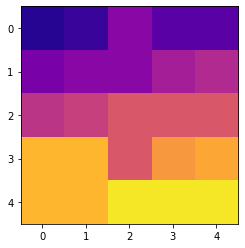

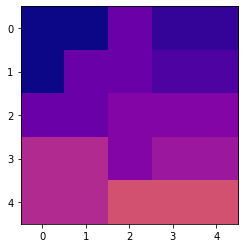

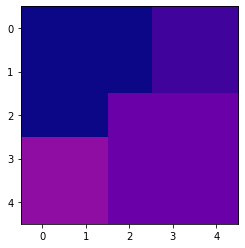

Pattern: 8; Year: 7
Army Values Lords:  {1: 4.335977319116796, 2: 2.465573823511402, 3: 1.707077684691652, 4: 5.996917769087052, 5: 3.977952377678763, 6: 1.325061381198493, 7: 2.307784480764228, 8: 0, 9: 3.3264946234126516}
Neighbours Lords:  {1: [4], 2: [3, 4], 3: [2, 5, 6], 4: [1, 2, 5, 7], 5: [9, 3, 4, 6], 6: [9, 3, 5], 7: [9, 4], 8: [], 9: [5, 6, 7]}
Lord Hitmap:  {}
adding 1.707077684691652*0.47074007470049994 to 0 from lord 3 to gov 3
adding 3.977952377678763*0.92274469442792 to 0.8035898768113048 from lord 5 to gov 3
adding 1.325061381198493*0.92274469442792 to 4.474224328001313 from lord 6 to gov 3
adding 2.307784480764228*0.46603267395349496 to 5.696917687293554 from lord 7 to gov 3
adding 3.3264946234126516*0.92274469442792 to 6.772420659772485 from lord 9 to gov 3
Army Values Govs:  {1: 0, 2: 0, 3: 9.84192592456951, 4: 0}
Neighbours Govs:  {1: [3, 3, 3], 2: [3, 3, 3], 3: [], 4: [3, 3]}
Govs Hitmap:  {}


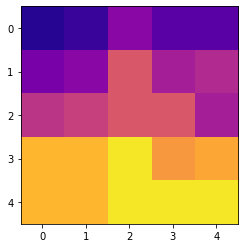

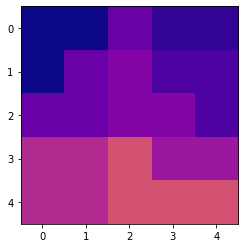

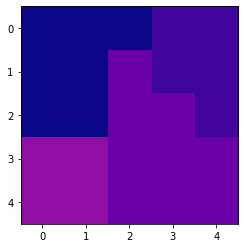

Pattern: 8; Year: 8
Army Values Lords:  {1: 4.5739808581505885, 2: 3.1233154691465677, 3: 3.395543608896692, 4: 4.350169132517097, 5: 4.597732306585164, 6: 1.3711893884729447, 7: 2.123014083151981, 8: 0, 9: 4.7247112039853905}
Neighbours Lords:  {1: [2, 4], 2: [1, 3, 5], 3: [2, 5], 4: [1, 5, 7], 5: [2, 3, 4, 6, 9], 6: [9, 5], 7: [9, 4], 8: [], 9: [5, 6, 7]}
Lord Hitmap:  {}
adding 4.5739808581505885*0.47074007470049994 to 0 from lord 1 to gov 3
adding 4.597732306585164*0.9135172474836407 to 2.153156090844465 from lord 5 to gov 3
adding 1.3711893884729447*0.9135172474836407 to 6.353263852222755 from lord 6 to gov 3
adding 2.123014083151981*0.46137234721396 to 7.605869008159336 from lord 7 to gov 3
adding 0*0.46137234721396 to 8.585368998871457 from lord 8 to gov 3
adding 4.7247112039853905*0.9135172474836407 to 8.585368998871457 from lord 9 to gov 3
Army Values Govs:  {1: 0, 2: 0, 3: 12.901474173091309, 4: 0}
Neighbours Govs:  {1: [3, 3, 3], 2: [3, 3], 3: [], 4: [3, 3]}
Govs Hitmap:  {}

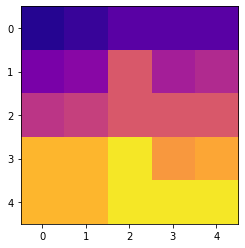

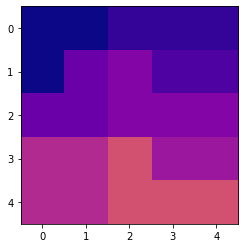

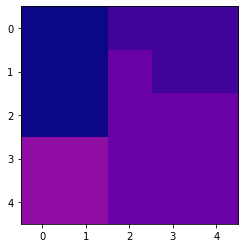

Pattern: 8; Year: 9
Army Values Lords:  {1: 3.877990337637753, 2: 3.3389786209325054, 3: 3.9340620262882986, 4: 6.581188359839069, 5: 3.7965959508869607, 6: 4.0624842809395485, 7: 2.763791621226906, 8: 0, 9: 4.875523766372464}
Neighbours Lords:  {1: [4], 2: [3, 4, 5], 3: [2, 5, 6], 4: [1, 2, 5, 7], 5: [2, 3, 4, 6, 9], 6: [9, 3, 5], 7: [9, 4], 8: [], 9: [5, 6, 7]}
Lord Hitmap:  {}
adding 3.7965959508869607*0.9043820750088043 to 0 from lord 5 to gov 3
adding 4.0624842809395485*0.9043820750088043 to 3.433573324033174 from lord 6 to gov 3
adding 0*0.45675862374182036 to 7.107611287719934 from lord 8 to gov 3
adding 4.875523766372464*0.9043820750088043 to 7.107611287719934 from lord 9 to gov 3
Army Values Govs:  {1: 0, 2: 0, 3: 11.516947588306603, 4: 0}
Neighbours Govs:  {1: [3, 3, 3], 2: [3, 3, 3], 3: [], 4: [3, 3]}
Govs Hitmap:  {}


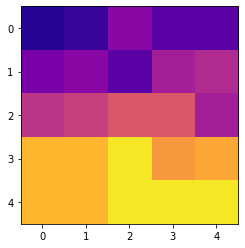

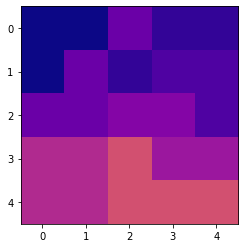

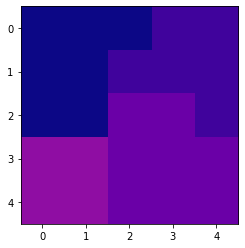

Simulate next pattern?: y/n y
Pattern: 9; Year: 0
Army Values Lords:  {1: 3.00465, 2: 2.52846, 3: 3.9708900000000003, 4: 1.99584, 5: 2.4423299999999997, 6: 3.4095599999999995, 7: 1.71369, 8: 2.47698, 9: 2.43738}
Neighbours Lords:  {1: [2, 4], 2: [1, 3, 4, 5], 3: [2, 5, 6], 4: [1, 2, 5, 7, 8], 5: [2, 3, 4, 6, 8], 6: [8, 9, 3, 5], 7: [8, 4], 8: [4, 5, 6, 7, 9], 9: [8, 6]}
Lord Hitmap:  {}
adding 3.00465*0.99 to 0 from lord 1 to gov 1
adding 1.99584*0.99 to 2.9746034999999997 from lord 4 to gov 1
adding 2.52846*0.99 to 0 from lord 2 to gov 2
adding 3.9708900000000003*0.99 to 2.5031754 from lord 3 to gov 2
adding 2.4423299999999997*0.99 to 0 from lord 5 to gov 3
adding 3.4095599999999995*0.99 to 2.4179066999999996 from lord 6 to gov 3
adding 2.43738*0.99 to 5.793371099999999 from lord 9 to gov 3
adding 1.71369*0.99 to 0 from lord 7 to gov 4
adding 2.47698*0.99 to 1.6965530999999998 from lord 8 to gov 4
Army Values Govs:  {1: 4.9504851, 2: 6.4343565, 3: 8.2063773, 4: 4.1487633}
Neighbours G

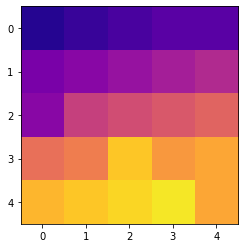

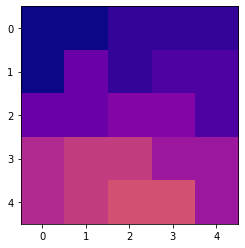

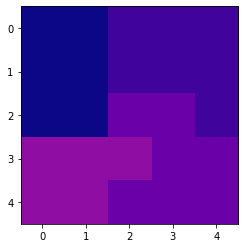

Pattern: 9; Year: 1
Army Values Lords:  {1: 3.4136882999999996, 2: 2.5845237, 3: 2.8266084, 4: 2.8648322999999998, 5: 1.4544683999999999, 6: 4.6319526, 7: 1.7465382, 8: 2.2071851999999996, 9: 2.793285}
Neighbours Lords:  {1: [2, 4, 7], 2: [1, 3, 4, 5], 3: [2, 6], 4: [8, 1, 2, 5], 5: [9, 2, 4, 6], 6: [9, 3, 5], 7: [8, 1], 8: [9, 4, 7], 9: [8, 5, 6]}
Lord Hitmap:  {}
adding 3.4136882999999996*0.9801 to 0 from lord 1 to gov 1
adding 2.8648322999999998*0.9801 to 3.3457559028299997 from lord 4 to gov 1
adding 2.5845237*0.9801 to 0 from lord 2 to gov 2
adding 2.8266084*0.9801 to 2.53309167837 from lord 3 to gov 2
adding 1.4544683999999999*0.9801 to 0 from lord 5 to gov 3
adding 4.6319526*0.9801 to 1.4255244788399999 from lord 6 to gov 3
adding 2.793285*0.9801 to 5.9653012221 from lord 9 to gov 3
Army Values Govs:  {1: 6.153578040059999, 2: 5.30345057121, 3: 8.7029998506, 4: 0}
Neighbours Govs:  {1: [2, 3, 3, 3], 2: [1, 1, 3, 3], 3: [1, 2, 2, 1], 4: [1, 1, 3]}
Govs Hitmap:  {3: 2}


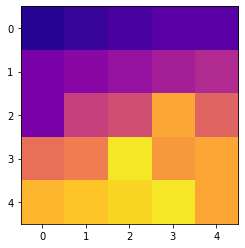

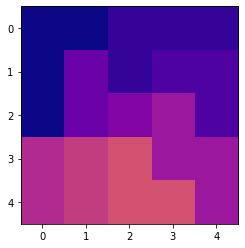

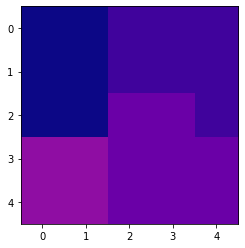

Pattern: 9; Year: 2
Army Values Lords:  {1: 3.3679078289999995, 2: 2.5159853069999993, 3: 4.264464105, 4: 3.028303179, 5: 1.5553892969999998, 6: 4.442999121, 7: 1.8086373359999999, 8: 2.715866901, 9: 2.8381245749999997}
Neighbours Lords:  {1: [2, 4], 2: [1, 3, 4, 5], 3: [2, 6], 4: [1, 2, 5, 7, 8], 5: [8, 2, 4, 6], 6: [8, 9, 3, 5], 7: [8, 4], 8: [4, 5, 6, 7, 9], 9: [8, 6]}
Lord Hitmap:  {}
adding 3.3679078289999995*0.9702989999999999 to 0 from lord 1 to gov 1
adding 3.028303179*0.9702989999999999 to 3.26787759857087 from lord 4 to gov 1
adding 2.5159853069999993*0.495 to 0 from lord 2 to gov 3
adding 1.5553892969999998*0.9702989999999999 to 1.2454127269649997 from lord 5 to gov 3
adding 4.442999121*0.9702989999999999 to 2.7546054064548025 from lord 6 to gov 3
adding 2.715866901*0.49005 to 7.065643010561981 from lord 8 to gov 3
adding 2.8381245749999997*0.9702989999999999 to 8.396553585397031 from lord 9 to gov 3
Army Values Govs:  {1: 6.206237144851391, 2: 0, 3: 11.150383022394955, 4: 0

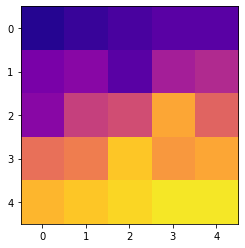

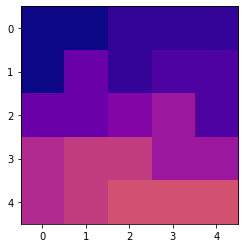

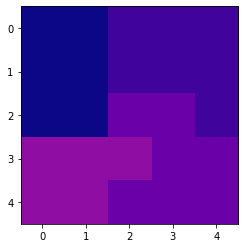

Pattern: 9; Year: 3
Army Values Lords:  {1: 3.8308568878799996, 2: 2.71272313224, 3: 2.9058029302499997, 4: 3.19590292527, 5: 1.5686532843299998, 6: 4.6963538928899995, 7: 1.37653408233, 8: 3.3909039153, 9: 2.62434829932}
Neighbours Lords:  {1: [8, 2, 4], 2: [1, 3, 4, 5], 3: [2, 6], 4: [8, 1, 2, 5], 5: [8, 2, 4, 6], 6: [8, 9, 3, 5], 7: [8], 8: [1, 4, 5, 6, 7, 9], 9: [8, 6]}
Lord Hitmap:  {}
adding 2.71272313224*0.49005 to 0 from lord 2 to gov 3
adding 1.5686532843299998*0.96059601 to 1.329369970954212 from lord 5 to gov 3
adding 4.6963538928899995*0.96059601 to 2.8362120569550053 from lord 6 to gov 3
adding 2.62434829932*0.96059601 to 7.3475108680131065 from lord 9 to gov 3
Army Values Govs:  {1: 0, 2: 0, 3: 9.868449373190185, 4: 0}
Neighbours Govs:  {1: [3, 3, 3], 2: [3, 3, 3, 3], 3: [], 4: [3, 3, 3, 3, 3]}
Govs Hitmap:  {}


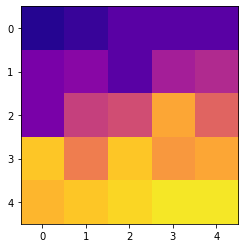

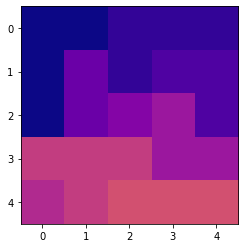

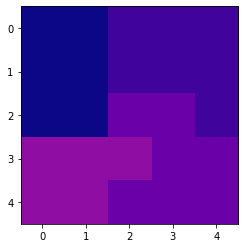

Pattern: 9; Year: 4
Army Values Lords:  {1: 4.0455116722746, 2: 2.8672350004485, 3: 4.5191047171248, 4: 3.2390721099593995, 5: 0, 6: 4.8586081649391, 7: 1.4806915076943, 8: 3.5129572443305994, 9: 2.7597731248098}
Neighbours Lords:  {1: [8, 2, 4], 2: [1, 3, 4, 5], 3: [2, 6], 4: [8, 1, 2, 5], 5: [8, 2, 4, 6], 6: [8, 9, 3, 5], 7: [8], 8: [1, 4, 5, 6, 7, 9], 9: [8, 6]}
Lord Hitmap:  {}
adding 4.0455116722746*0.49005 to 0 from lord 1 to gov 3
adding 0*0.9509900498999999 to 1.9825029949981676 from lord 5 to gov 3
adding 4.8586081649391*0.9509900498999999 to 1.9825029949981676 from lord 6 to gov 3
adding 2.7597731248098*0.9509900498999999 to 6.602991016218149 from lord 9 to gov 3
Army Values Govs:  {1: 0, 2: 0, 3: 9.227507797893699, 4: 0}
Neighbours Govs:  {1: [3, 3, 3], 2: [3, 3, 3, 3], 3: [], 4: [3, 3, 3, 3, 3]}
Govs Hitmap:  {}


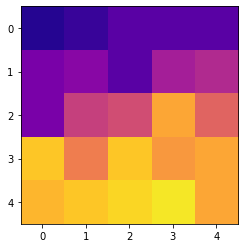

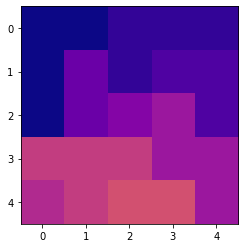

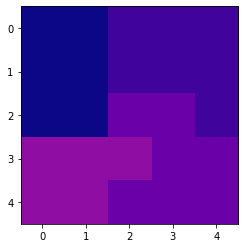

Pattern: 9; Year: 5
Army Values Lords:  {1: 3.183144385124781, 2: 4.419307821288294, 3: 3.217037670503217, 4: 3.4345195850148476, 5: 1.7012546299676068, 6: 5.366436851585699, 7: 1.5073097191910008, 8: 3.6896607055025186, 9: 2.9835505934517688}
Neighbours Lords:  {1: [8, 2, 4], 2: [1, 3, 4, 5, 6], 3: [2, 6], 4: [8, 1, 2, 5], 5: [8, 2, 4, 6], 6: [2, 3, 5, 8, 9], 7: [8], 8: [1, 4, 5, 6, 7, 9], 9: [8, 6]}
Lord Hitmap:  {}
adding 3.183144385124781*0.48514949999999996 to 0 from lord 1 to gov 3
adding 4.419307821288294*0.480298005 to 1.5443009068710947 from lord 2 to gov 3
adding 3.4345195850148476*0.48514949999999996 to 3.666885636916759 from lord 4 to gov 3
adding 1.7012546299676068*0.9414801494009999 to 5.333141096326919 from lord 5 to gov 3
adding 5.366436851585699*0.9414801494009999 to 6.9348385595179645 from lord 6 to gov 3
adding 3.6896607055025186*0.47549502494999996 to 11.9872323282999 from lord 8 to gov 3
adding 2.9835505934517688*0.9414801494009999 to 13.741647637519854 from lord 9

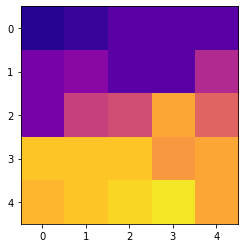

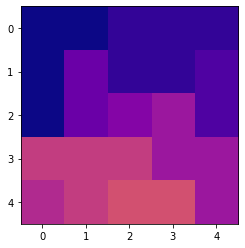

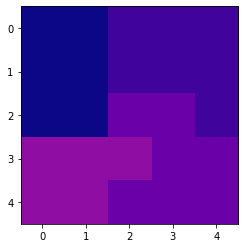

Pattern: 9; Year: 6
Army Values Lords:  {1: 4.53636204826332, 2: 4.408669095600062, 3: 3.413223304035397, 4: 3.6574244251870285, 5: 1.7075437173656056, 6: 5.5895958913982176, 7: 1.5201985824363005, 8: 3.9016255463386598, 9: 2.015125282174912}
Neighbours Lords:  {1: [8, 2, 4], 2: [1, 3, 4, 5, 6], 3: [2, 6], 4: [8, 1, 2, 5], 5: [8, 2, 4, 6], 6: [2, 3, 5, 8, 9], 7: [8], 8: [1, 4, 5, 6, 7, 9], 9: [8, 6]}
Lord Hitmap:  {}
adding 4.53636204826332*0.480298005 to 0 from lord 1 to gov 3
adding 4.408669095600062*0.47549502494999996 to 2.1788056417385864 from lord 2 to gov 3
adding 1.7075437173656056*0.9320653479069899 to 4.275105863347232 from lord 5 to gov 3
adding 5.5895958913982176*0.9320653479069899 to 5.86664819234 from lord 6 to gov 3
adding 3.9016255463386598*0.47074007470049994 to 11.07651683151556 from lord 8 to gov 3
adding 2.015125282174912*0.9320653479069899 to 12.9131683326524 from lord 9 to gov 3
Army Values Govs:  {1: 0, 2: 0, 3: 14.791396779858932, 4: 0}
Neighbours Govs:  {1: [3,

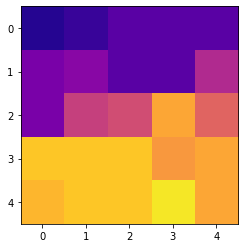

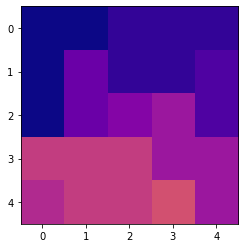

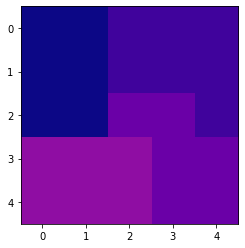

Pattern: 9; Year: 7
Army Values Lords:  {1: 2.846667382310133, 2: 6.109492621807258, 3: 1.9294591560487808, 4: 3.9004418233468177, 5: 1.8058113669954394, 6: 5.639815572343446, 7: 1.5742024486940314, 8: 2.747010955311918, 9: 0.3737116012433076}
Neighbours Lords:  {1: [8, 2, 4], 2: [1, 3, 4, 5, 6], 3: [2, 6], 4: [8, 1, 2, 5], 5: [9, 2, 4, 6], 6: [9, 2, 3, 5], 7: [8], 8: [1, 4, 9, 7], 9: [8, 5, 6]}
Lord Hitmap:  {}
adding 3.9004418233468177*0.47549502494999996 to 0 from lord 4 to gov 3
adding 1.8058113669954394*0.92274469442792 to 1.8546406821083183 from lord 5 to gov 3
adding 5.639815572343446*0.92274469442792 to 3.5209435401409896 from lord 6 to gov 3
adding 0.3737116012433076*0.92274469442792 to 8.725053437072868 from lord 9 to gov 3
Army Values Govs:  {1: 0, 2: 0, 3: 9.069893834366292, 4: 0}
Neighbours Govs:  {1: [3, 3, 3], 2: [3, 3, 3, 3], 3: [], 4: [3, 3, 3]}
Govs Hitmap:  {}


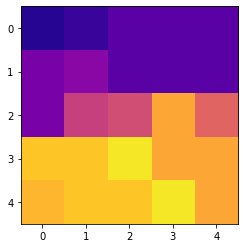

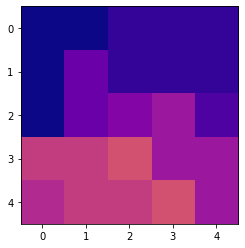

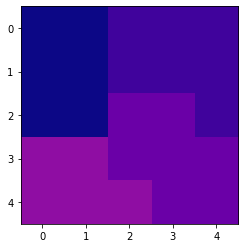

Pattern: 9; Year: 8
Army Values Lords:  {1: 3.5937768516006425, 2: 6.812098114485508, 3: 0, 4: 4.148281820823213, 5: 1.8407372536795361, 6: 7.467089980931279, 7: 1.6964015285771208, 8: 3.2265429181122194, 9: 2.155900704061392}
Neighbours Lords:  {1: [8, 2, 4], 2: [1, 4, 5, 6], 3: [], 4: [8, 1, 2, 5], 5: [8, 2, 4, 6], 6: [8, 9, 2, 5], 7: [8], 8: [1, 4, 5, 6, 7, 9], 9: [8, 6]}
Lord Hitmap:  {}
adding 6.812098114485508*0.46603267395349496 to 0 from lord 2 to gov 3
adding 1.8407372536795361*0.9135172474836407 to 3.1746602995272424 from lord 5 to gov 3
adding 7.467089980931279*0.9135172474836407 to 4.856205528849168 from lord 6 to gov 3
adding 2.155900704061392*0.9135172474836407 to 11.677521014942181 from lord 9 to gov 3
Army Values Govs:  {1: 0, 2: 0, 3: 13.646973491964387, 4: 0}
Neighbours Govs:  {1: [3, 3, 3], 2: [3, 3, 3, 3], 3: [], 4: [3, 3, 3, 3, 3]}
Govs Hitmap:  {}


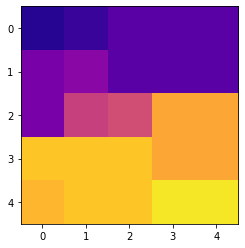

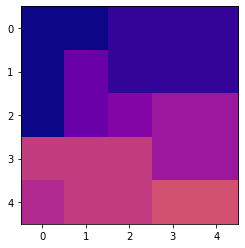

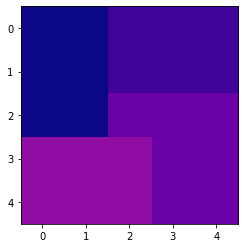

Pattern: 9; Year: 9
Army Values Lords:  {1: 3.1273532153804453, 2: 5.418153011377747, 3: 0, 4: 4.672037799495483, 5: 0, 6: 7.819287420526122, 7: 0, 8: 5.728356063105767, 9: 2.7972537580022316}
Neighbours Lords:  {1: [2, 4], 2: [1, 4, 5, 6], 3: [], 4: [8, 1, 2, 5], 5: [8, 2, 4, 6], 6: [8, 9, 2, 5], 7: [8], 8: [4, 5, 6, 7, 9], 9: [8, 6]}
Lord Hitmap:  {}
adding 5.418153011377747*0.46137234721396 to 0 from lord 2 to gov 3
adding 0*0.46137234721396 to 2.499785972423737 from lord 3 to gov 3
adding 4.672037799495483*0.46603267395349496 to 2.499785972423737 from lord 4 to gov 3
adding 0*0.9043820750088043 to 4.67710824093442 from lord 5 to gov 3
adding 7.819287420526122*0.9043820750088043 to 4.67710824093442 from lord 6 to gov 3
adding 5.728356063105767*0.45675862374182036 to 11.748731623400074 from lord 8 to gov 3
adding 2.7972537580022316*0.9043820750088043 to 14.365207655087376 from lord 9 to gov 3
Army Values Govs:  {1: 0, 2: 0, 3: 16.89499381307561, 4: 0}
Neighbours Govs:  {1: [3, 3, 3],

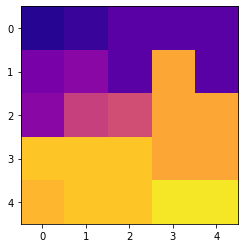

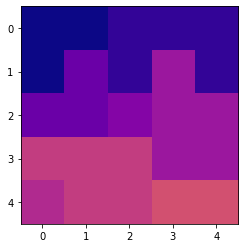

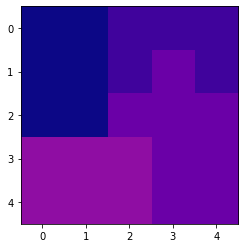

KeyboardInterrupt: ignored

In [6]:
#main

# Simulate and plot results
nice_patterns = [(7, "remontada"), (8, "dos lords"), (12, "")]
init_pattern = input("Initial Pattern?: ")

for p in range(int(init_pattern), 40):

  initialize(pattern=p, printy=False)
  for year in range(10):
      print("Pattern: {}; Year: {}".format(p, year))
      update(printy=False)
      observe(year, ca_level="vassal", color_map="plasma")
      display.display(gcf())
      observe(year, ca_level="lord", color_map="plasma")
      display.display(gcf())
      observe(year, ca_level="governor", color_map="plasma")
      display.display(gcf())
      time.sleep(0.4)
      #display.clear_output(wait=True) #comment for whole output
      plt.close()
  plt.show()

  inp = input("Simulate next pattern?: y/n ").lower()
  if inp != "y":
    break

